In [1]:
"""
 * @ Author: Lucas Glasner (lgvivanco96@gmail.com)
 * @ Create Time: 1969-12-31 21:00:00
 * @ Modified by: Lucas Glasner, 
 * @ Modified time: 2024-03-21 15:35:44
 * @ Description:
 * @ Dependencies:
 */
"""

import os
import sys
import tqdm
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import pandas as pd
from geocube.vector import vectorize
import tempfile

KeyboardInterrupt: 

In [ ]:
def saga_cmd(program_type, program_number, execute=True,
             logpath='log.txt', **kwargs):
    """
    Simple python wrapper of the command line program 'saga_cmd'
    
    Reference:
        https://saga-gis.sourceforge.io/saga_tool_doc/9.4.0/a2z.html
    
    Args:
        program_type (str): SAGA tool library name (e.g ta_hydrology)
        program_number (int): Tool number.
        execute (bool): True to run the command in the shell. Defaults to True.
        logpath (str): Path to store the command line printable output.
            Defaults to log.txt. 
        **kwargs are used to build the specific tool arguments. 

    Returns:
        (str): Full command as string
    """
    if os.name == 'nt':
        command = 'saga_cmd.exe {} {} {} >> '+logpath
        arguments = [f"-{opt}={val}" for opt, val in kwargs.items()]
    else:
        command = 'saga_cmd {} {} {} >> '+logpath
        arguments = [f"-{opt} '{val}'" for opt, val in kwargs.items()]
    arguments = ' '.join(arguments)
    command   = command.format(program_type,
                               program_number,
                               arguments)
    if execute:
        os.system(command)
    return command

def saga_loadgrid(path, overwrite=True, **kwargs):
    """
    This function loads a grid computed with SAGA GIS into a 
    python xarray object. It uses SAGA utilities to transform 
    the .sgrd objecto to geotiff, then just uses rioxarray. 

    Args:
        path (str): Path to grid. 
        overwrite (bool, optional): Defaults to True.

    Returns:
        (xr.DataArray): loaded grid
    """    
    npath = path.replace('.sgrd','.tif')
    if overwrite:
        try:
            os.remove(npath)
        except:
            pass
    if os.path.isfile(npath):
        grid = rxr.open_rasterio(npath, **kwargs)
        grid.attrs['local_path'] = npath
        return grid
    else:
        saga_cmd("io_gdal", 1,
                FORMAT=1,
                GRIDS=path,
                FILE=npath)
        grid = rxr.open_rasterio(npath, **kwargs)
        grid.attrs['local_path'] = npath
        return grid
    
def Preprocess_DEM(outdir, DEM, **kwargs):
    if os.name == 'nt':
        fsep = '\\'
        gext = '.tif'
    else:
        fsep = '/'
        gext = '.sgrd'
    DEM_path = DEM.attrs['local_path']
    saga_cmd('ta_preprocessor', 1,
            ELEVATION=DEM_path,
            SINKROUTE=f'{outdir}{fsep}sinks{gext}')
    saga_cmd('ta_preprocessor', 2,
            DEM=DEM_path,
            SINKROUTE=f'{outdir}{fsep}sinks{gext}',
            DEM_PREPROC=f'{outdir}{fsep}deep_dem{gext}',
            METHOD=0)
    saga_cmd('ta_preprocessor', 7,
            DEM=f'{outdir}{fsep}deep_dem{gext}',
            NOSINKS=f'{outdir}{fsep}nosink{gext}')
    if os.name == 'nt':
        sinks  = rxr.open_rasterio(f'{outdir}{fsep}sinks{gext}', **kwargs)
        nosink = rxr.open_rasterio(f'{outdir}{fsep}nosink{gext}', **kwargs)
        
        sinks.attrs['local_path'] = f'{outdir}{fsep}sinks{gext}'
        nosink.attrs['local_path'] = f'{outdir}{fsep}nosink{gext}'
    else:
        sinks  = saga_loadgrid(f'{outdir}{fsep}sinks{gext}', **kwargs)
        nosink = saga_loadgrid(f'{outdir}{fsep}nosink{gext}', **kwargs)
    return nosink, sinks

def GetRiverNetwork(DEM, outdir, THRESHOLD=5, **kwargs):
    if os.name == 'nt':
        fsep = '\\'
    else:
        fsep = '/'
    DEM_path = DEM.attrs['local_path']
    saga_cmd('ta_channels',5,
             DEM=DEM_path,
             NODES=f'{outdir}{fsep}junctions.shp',
             SEGMENTS=f'{outdir}{fsep}rnetwork.shp',
             THRESHOLD=THRESHOLD)
    junctions = gpd.read_file(f'{outdir}{fsep}junctions.shp', **kwargs)
    rnetwork = gpd.read_file(f'{outdir}{fsep}rnetwork.shp', **kwargs)
    return rnetwork, junctions

def snap2line(outdir, path_points, path_lines, distance=50):
    if os.name == 'nt':
        fsep = '\\'
    else:
        fsep = '/'
    saga_cmd('shapes_points', 19,
             INPUT=path_points,
             SNAP=path_lines,
             OUTPUT=f'{outdir}{fsep}output.shp',
             DISTANCE=distance)
    output = gpd.read_file(f'{outdir}{fsep}output.shp')
    return output


def BasinDelination(outdir, DEM, fid, x_out, y_out):
    if os.name == 'nt':
        fsep = '\\'
        gext = '.tif'
    else:
        fsep = '/'
        gext = '.sgrd'
    DEM_path = DEM.attrs['local_path']
    saga_cmd('ta_hydrology', 4,
            TARGET_PT_X=x_out,
            TARGET_PT_Y=y_out,
            ELEVATION=DEM_path,
            AREA=f'{outdir}{fsep}Basin_{fid}{gext}',
            METHOD=0)
    basin = rxr.open_rasterio(f'{outdir}{fsep}Basin_{fid}{gext}', masked=True)
    basin = basin.where(basin>0)
    basin = basin.dropna('x', how='all').dropna('y', how='all')
    basin.name = f'Basin_{fid}'
    basin = vectorize(basin).dropna()
    basin = gpd.GeoDataFrame(geometry=basin['geometry'])
    basin['fid'] = np.ones(len(basin))*fid
    return basin
    
    

In [ ]:
dem_path     = 'data/DEMs/NASADEM/NASADEM_UTM_subset.tif'
tmpdir       = tempfile.mkdtemp()
rawdem       = rxr.open_rasterio(dem_path, masked=True)
rawdem.attrs['local_path'] = dem_path

In [ ]:
print('DEM preprocess...')
nosink, sinks = Preprocess_DEM(DEM=rawdem,
                            outdir=tmpdir,
                            masked=True) 
print('Computing River Network...')
rnetwork, junctions = GetRiverNetwork(DEM=nosink,
                                    outdir=tmpdir,
                                    THRESHOLD=4,
                                    masked=True)

DEM preprocess...
Computing River Network...


In [ ]:
rnetwork.to_file('data/rnetwork.gpkg')

In [ ]:

print('Snapping streamflow gauge to river network...')
outlets_snapped = snap2line(path_points='data/outlets.shp',
                            path_lines=f'data/rnetwork.gpkg',
                            outdir=tmpdir,
                            distance=100)

outlets_snapped['Nombre'] = outlets_snapped.index.map(lambda x: str(x))

Snapping streamflow gauge to river network...


In [ ]:

print('Basin delination...')
Basins = []
for fid,x,y in tqdm.tqdm(zip(outlets_snapped.index,
                             outlets_snapped.geometry.x,
                             outlets_snapped.geometry.y),
                            total=len(outlets_snapped)):
    basin  = BasinDelination(tmpdir, nosink, fid, x, y).drop('fid', axis=1)
    name   = outlets_snapped.loc[fid].Nombre
    basin['outlet_x'] = x
    basin['outlet_y'] = y
    basin['Name']     = name
    basin.to_file(f'data/shapes/basins/{name.replace(' ','')}.gpkg')
    basin_rnetwork = rnetwork.clip(basin.geometry)
    basin_rnetwork.to_file(f'data/shapes/rnetwork/rnetwork_{name.replace(' ','')}.gpkg')
    
    
    Basins.append(basin)
Basins = pd.concat(Basins, axis=0)
Basins = Basins.reset_index(drop=True)
Basins.to_file('data/shapes/basins/Basins.gpkg')
print('Done')

Basin delination...


100%|██████████| 3/3 [00:10<00:00,  3.43s/it]

Done


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

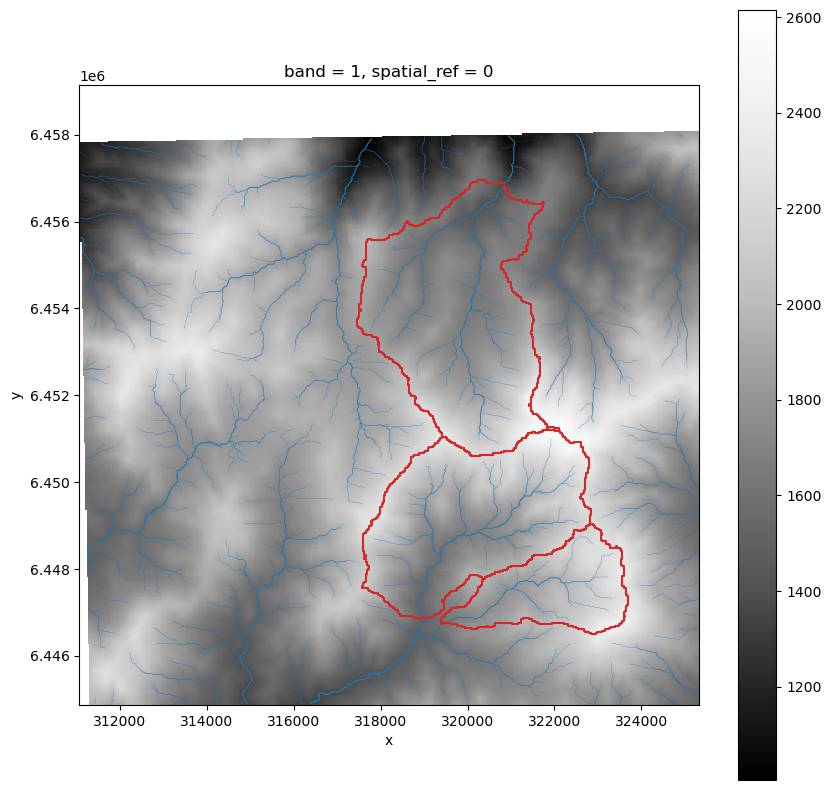

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,10))
rawdem.squeeze().plot(ax=ax, cmap='Greys_r')
rnetwork.plot(linewidth=rnetwork['ORDER']/5, ax=ax)
Basins.boundary.plot(ax=ax, color='tab:red')